In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import random
from models import HybridLoss
from etl_data import spine_dataset, load_data, split_data
from models import ImprovedAttentionUNet
from sched import scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

/home/igor-lechoszest/anaconda3/envs/AI_Diag/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Funkcja do testowania modeli

In [2]:
def evaluate_on_test_set(model, test_loader, device, num_classes=4):
    """
    Funkcja pomocnicza: Oblicza metryki i wizualizuje wyniki na zbiorze testowym.
    """
    model.eval()
    dice_scores = torch.zeros(num_classes).to(device)
    class_counts = torch.zeros(num_classes).to(device)
    class_names = ["Tło", "Kręgi", "Dyski", "Sacrum"]
    
    # Zbieramy próbki do wizualizacji
    visual_samples = []
    
    print("\n--- ROZPOCZYNAM TESTOWANIE NA ZBIORZE TESTOWYM ---")
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(test_loader):
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.long)
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            # 1. Obliczanie Dice Score
            for cls in range(num_classes):
                pred_inds = (preds == cls)
                target_inds = (masks == cls)
                
                if target_inds.sum() > 0: # Liczymy tylko jeśli klasa istnieje w obrazie
                    intersection = (pred_inds & target_inds).float().sum()
                    union = pred_inds.float().sum() + target_inds.float().sum()
                    dice = (2. * intersection) / (union + 1e-8)
                    dice_scores[cls] += dice
                    class_counts[cls] += 1
            
            # 2. Zapisywanie kilku próbek do późniejszego wyświetlenia
            # Bierzemy pierwszy obraz z każdego batcha, aż uzbieramy np. 3 sztuki
            if len(visual_samples) < 3:
                img_np = images[0, 0].cpu().numpy() # (H, W)
                mask_true_np = masks[0].cpu().numpy()
                mask_pred_np = preds[0].cpu().numpy()
                visual_samples.append((img_np, mask_true_np, mask_pred_np))

    # --- RAPORT WYNIKÓW ---
    avg_dice = dice_scores / (class_counts + 1e-8)
    
    print("\n=== WYNIKI TESTU (DICE SCORE) ===")
    print(f"{'Klasa':<20} | {'Dice Score':<10}")
    print("-" * 35)
    for i in range(num_classes):
        print(f"{class_names[i]:<20} | {avg_dice[i].item():.4f}")
    print("-" * 35)
    print(f"Średni Dice (bez tła): {avg_dice[1:].mean().item():.4f}")
    
    # --- WIZUALIZACJA ---
    print("\nWyświetlam przykłady ze zbioru testowego...")
    for i, (img, true_m, pred_m) in enumerate(visual_samples):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'Próbka Testowa #{i+1}', fontsize=16)
        
        ax[0].imshow(img, cmap='gray')
        ax[0].set_title("MRI (Wejście)")
        ax[0].axis('off')
        
        ax[1].imshow(true_m, cmap='jet', vmin=0, vmax=3)
        ax[1].set_title("Prawda (Ground Truth)")
        ax[1].axis('off')
        
        ax[2].imshow(pred_m, cmap='jet', vmin=0, vmax=3)
        ax[2].set_title(f"Predykcja Modelu")
        ax[2].axis('off')
        
        plt.show()

## Funkcja ładdująca dane

In [3]:
def data_loading_for_model():
    print("Wczytywanie i dzielenie danych...")
    imgs, masks, types = load_data()

    train_imgs, train_masks, train_types, val_imgs, val_masks, val_types, test_imgs, test_masks, test_types = split_data(imgs, masks, types, train_frac=0.7, val_frac=0.2, seed=2026)
        
    train_ds = spine_dataset(train_imgs, train_masks, train_types, train=True)
    val_ds   = spine_dataset(val_imgs, val_masks, val_types, train=False)
    test_ds  = spine_dataset(test_imgs, test_masks, test_types, train=False)
    
    print(f"Dane podzielone:")
    print(f"  -> Trening:   {len(train_ds)} (70%)")
    print(f"  -> Walidacja: {len(val_ds)} (20%)")
    print(f"  -> Test:      {len(test_ds)} (10%)")

    # DataLoader'y
    batch_size = 4
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0) # Batch 1 dla testu jest wygodniejszy

    return train_loader, val_loader, test_loader

## Model z papera

Używam GPU (CUDA)
Wczytywanie i dzielenie danych...
Dane podzielone:
  -> Trening:   256 (70%)
  -> Walidacja: 73 (20%)
  -> Test:      38 (10%)
Rozpoczynam trening na 10 epok z Schedulerem...


/home/igor-lechoszest/anaconda3/envs/AI_Diag/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Epoka [1/10] | LR: 1.00e-04 | Train Loss: 0.8865 | Val Loss: 0.9774
Epoka [2/10] | LR: 1.00e-04 | Train Loss: 0.4590 | Val Loss: 0.3912
Epoka [3/10] | LR: 1.00e-04 | Train Loss: 0.3594 | Val Loss: 0.3024
Epoka [4/10] | LR: 1.00e-04 | Train Loss: 0.2898 | Val Loss: 0.2701
Epoka [5/10] | LR: 1.00e-04 | Train Loss: 0.2547 | Val Loss: 0.2368
Epoka [6/10] | LR: 1.00e-04 | Train Loss: 0.2270 | Val Loss: 0.2054
Epoka [7/10] | LR: 1.00e-04 | Train Loss: 0.2100 | Val Loss: 0.1992
Epoka [8/10] | LR: 1.00e-04 | Train Loss: 0.1890 | Val Loss: 0.1709
Epoka [9/10] | LR: 1.00e-04 | Train Loss: 0.1778 | Val Loss: 0.1972
Epoka [10/10] | LR: 1.00e-04 | Train Loss: 0.1701 | Val Loss: 0.1652

Trening zakończony. Wczytuję najlepszy model do testów...

--- ROZPOCZYNAM TESTOWANIE NA ZBIORZE TESTOWYM ---

=== WYNIKI TESTU (DICE SCORE) ===
Klasa                | Dice Score
-----------------------------------
Tło                  | 0.9886
Kręgi                | 0.9060
Dyski                | 0.9015
Sacrum       

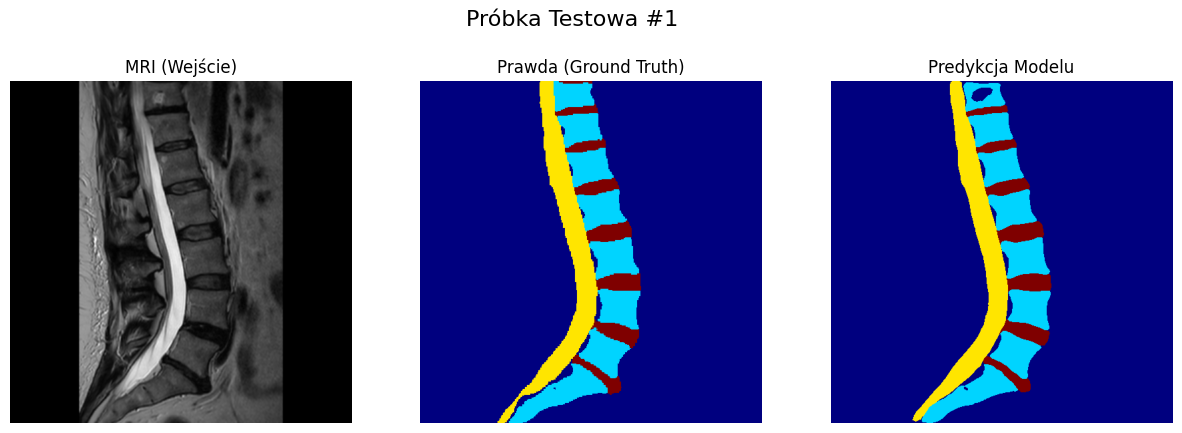

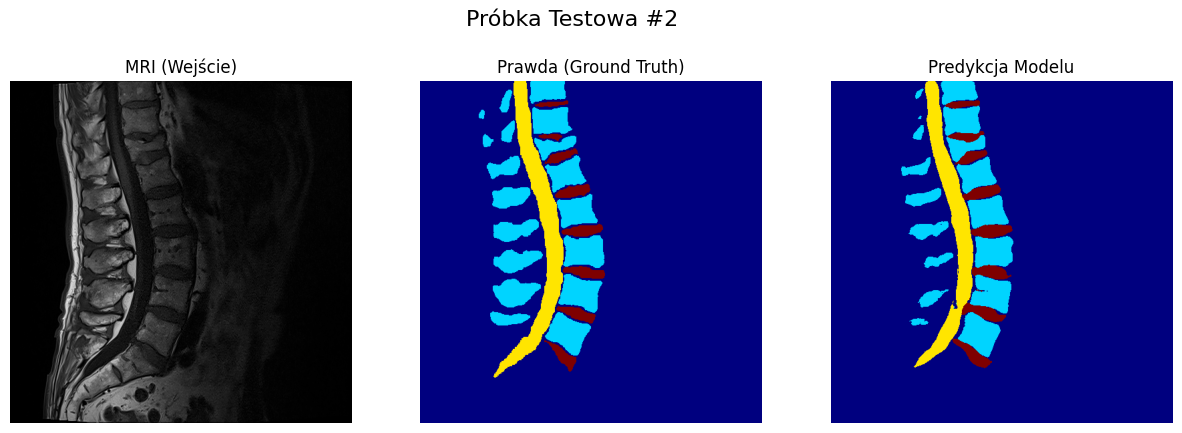

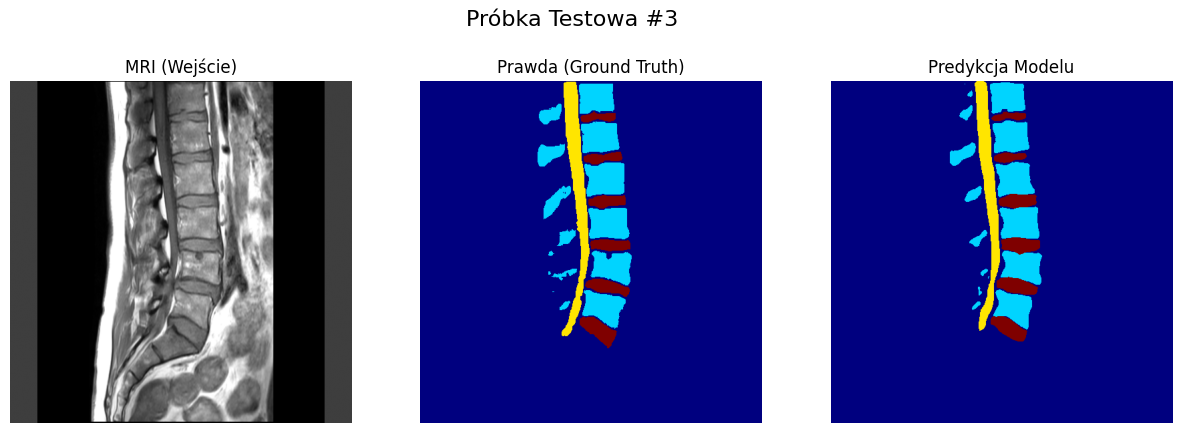

In [ ]:
def Paper_model():
    # 1. Konfiguracja
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("Używam GPU (CUDA)")
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        print("Używam GPU (Apple Metal)")
    else:
        device = torch.device('cpu')
        print("Używam CPU")

    # 2. Wczytanie danych
    train_loader, val_loader, test_loader = data_loading_for_model()

    # 3. Model i Trening
    num_classes = 4
    model = ImprovedAttentionUNet(img_ch=1, output_ch=num_classes).to(device)
    criterion = HybridLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    num_epochs = 100
    best_val_loss = float('inf')
    
    print(f"Rozpoczynam trening na {num_epochs} epok z Schedulerem...")
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for images, masks in train_loader:
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.long)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        avg_train_loss = train_loss / len(train_loader)
        
        # Walidacja
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device, dtype=torch.float32)
                masks = masks.to(device, dtype=torch.long)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        
        scheduler.step(avg_val_loss)
        
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"Epoka [{epoch+1}/{num_epochs}] | LR: {current_lr:.2e} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        
        # Zapisujemy najlepszy model (żeby testować najlepszą wersję, a nie ostatnią)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_paper_model.pth")

    print("\nTrening zakończony. Wczytuję najlepszy model do testów...")
    
    # 4. Wczytanie najlepszego modelu i TESTOWANIE
    model.load_state_dict(torch.load("best_paper_model.pth"))
    
    # Uruchomienie funkcji testującej i wizualizującej
    evaluate_on_test_set(model, test_loader, device, num_classes)

    return model

if __name__ == "__main__":
    try:
        Paper_model()
    except Exception as e:
        print(f"Błąd: {e}")

# Kod do puszczania już zapisanego modelu

Wczytywanie i dzielenie danych...
Dane podzielone:
  -> Trening:   256 (70%)
  -> Walidacja: 73 (20%)
  -> Test:      38 (10%)

--- ROZPOCZYNAM TESTOWANIE NA ZBIORZE TESTOWYM ---

=== WYNIKI TESTU (DICE SCORE) ===
Klasa                | Dice Score
-----------------------------------
Tło                  | 0.9368
Kręgi                | 0.1971
Dyski                | 0.3040
Sacrum               | 0.1844
-----------------------------------
Średni Dice (bez tła): 0.2285

Wyświetlam przykłady ze zbioru testowego...


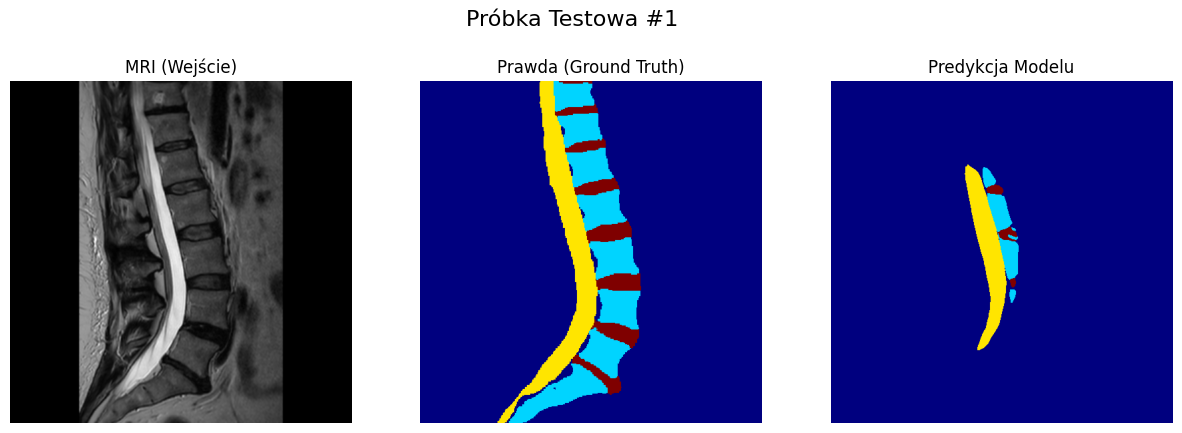

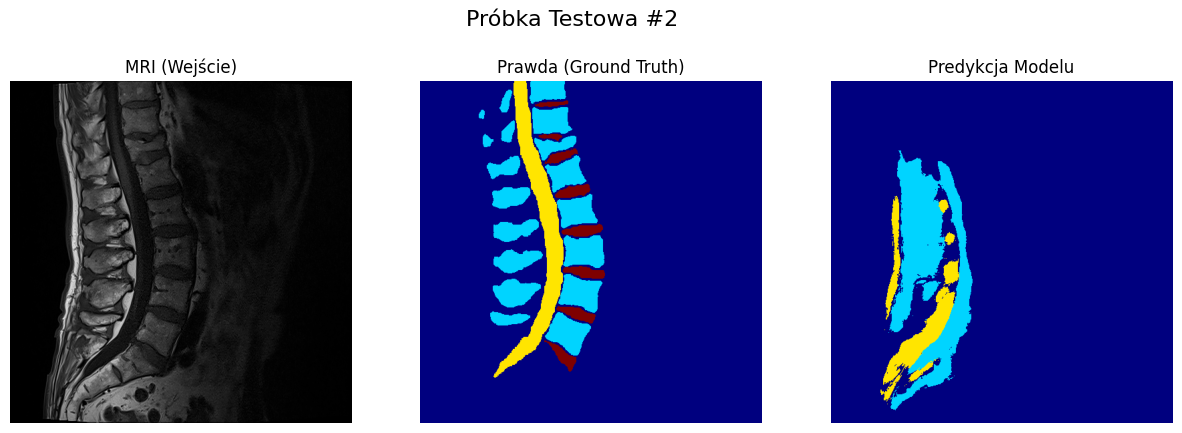

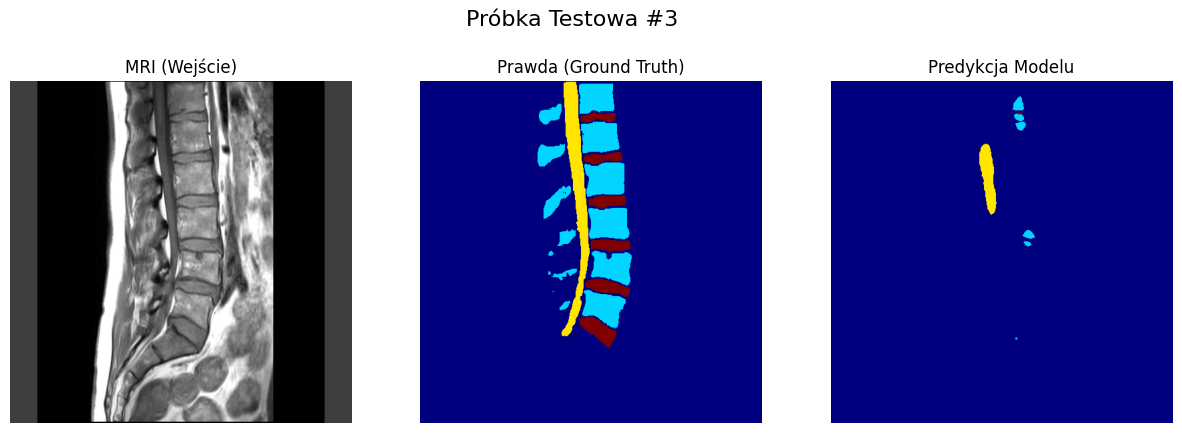

In [ ]:
test_loader = data_loading_for_model()[2]
model = ImprovedAttentionUNet(img_ch=1, output_ch=4).to('cuda')
model.load_state_dict(torch.load("best_paper_model.pth"))
evaluate_on_test_set(model, test_loader, 'cuda', 4)

# Modele z huggingface:

## model SegformerForSemanticSegmentation:

In [4]:
from transformers import SegformerForSemanticSegmentation

class HuggingFaceSegFormer(nn.Module):
    def __init__(self, num_classes=4, model_name="nvidia/mit-b0"):
        super().__init__()
        # Pobieramy pretrenowany model (np. mit-b0 to wersja najlżejsza)
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            model_name,
            num_labels=num_classes,
            num_channels=3, # Wymuszamy 3 kanały (standard ImageNet)
            ignore_mismatched_sizes=True
        )
        
    def forward(self, x):
        # 1. Konwersja MRI (1 kanał) -> RGB (3 kanały) poprzez powielenie
        # x shape: [Batch, 1, 512, 512] -> [Batch, 3, 512, 512]
        x = x.repeat(1, 3, 1, 1)
        
        # 2. Przejście przez model HuggingFace
        outputs = self.model(pixel_values=x)
        
        # 3. Upsampling (SegFormer zwraca wyjście 4x mniejsze, np. 128x128)
        # Musimy je powiększyć z powrotem do 512x512
        logits = nn.functional.interpolate(
            outputs.logits, 
            size=(512, 512), 
            mode="bilinear", 
            align_corners=False
        )
        
        return logits

In [ ]:
def TransferLearning_model1(model_name="nvidia/mit-b0"):
    print(f"--- URUCHAMIAM TRANSFER LEARNING: {model_name} ---")
    
    # 1. Konfiguracja (lokalna dla funkcji)
    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')

    # 2. Wczytanie danych (używamy tej samej funkcji co wcześniej)
    train_loader, val_loader, test_loader = data_loading_for_model()

    # 3. Inicjalizacja Modelu (TO JEST GŁÓWNA ZMIANA)
    num_classes = 4
    
    # Używamy naszego Wrappera zamiast ImprovedAttentionUNet
    model = HuggingFaceSegFormer(num_classes=num_classes, model_name=model_name).to(device)
    
    criterion = HybridLoss().to(device)
    
    # Przy Transfer Learningu często warto zacząć od nieco mniejszego LR
    optimizer = optim.Adam(model.parameters(), lr=5e-5) 
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    num_epochs = 10
    best_val_loss = float('inf')
    save_name = f"best_{model_name.replace('/', '_')}_model.pth" # np. best_nvidia_mit-b0_model.pth
    
    print(f"Rozpoczynam trening modelu {model_name}...")
    
    # --- Pętla treningowa jest identyczna jak w Paper_model ---
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for images, masks in train_loader:
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.long)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        avg_train_loss = train_loss / len(train_loader)
        
        # Walidacja
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device, dtype=torch.float32)
                masks = masks.to(device, dtype=torch.long)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"Epoka [{epoch+1}/{num_epochs}] | LR: {current_lr:.2e} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_name)

    print(f"\nTrening {model_name} zakończony. Testowanie...")
    
    # 4. Testowanie
    model.load_state_dict(torch.load(save_name))
    evaluate_on_test_set(model, test_loader, device, num_classes)

    return model

nvidia/mit-b0

>>> START: SEGFORMER B0 (Transfer Learning) <<<
--- URUCHAMIAM TRANSFER LEARNING: nvidia/mit-b0 ---
Wczytywanie i dzielenie danych...
Dane podzielone:
  -> Trening:   256 (70%)
  -> Walidacja: 73 (20%)
  -> Test:      38 (10%)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/igor-lechoszest/anaconda3/envs/AI_Diag/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Aff

Rozpoczynam trening modelu nvidia/mit-b0...
Epoka [1/10] | LR: 5.00e-05 | Train Loss: 1.6381 | Val Loss: 1.4490
Epoka [2/10] | LR: 5.00e-05 | Train Loss: 1.1182 | Val Loss: 0.9699
Epoka [3/10] | LR: 5.00e-05 | Train Loss: 0.8764 | Val Loss: 0.7337
Epoka [4/10] | LR: 5.00e-05 | Train Loss: 0.7108 | Val Loss: 0.5818
Epoka [5/10] | LR: 5.00e-05 | Train Loss: 0.5876 | Val Loss: 0.5229
Epoka [6/10] | LR: 5.00e-05 | Train Loss: 0.5083 | Val Loss: 0.4262
Epoka [7/10] | LR: 5.00e-05 | Train Loss: 0.4409 | Val Loss: 0.3734
Epoka [8/10] | LR: 5.00e-05 | Train Loss: 0.3916 | Val Loss: 0.3391
Epoka [9/10] | LR: 5.00e-05 | Train Loss: 0.3552 | Val Loss: 0.3110
Epoka [10/10] | LR: 5.00e-05 | Train Loss: 0.3231 | Val Loss: 0.2747

Trening nvidia/mit-b0 zakończony. Testowanie...

--- ROZPOCZYNAM TESTOWANIE NA ZBIORZE TESTOWYM ---

=== WYNIKI TESTU (DICE SCORE) ===
Klasa                | Dice Score
-----------------------------------
Tło                  | 0.9836
Kręgi                | 0.8702
Dyski    

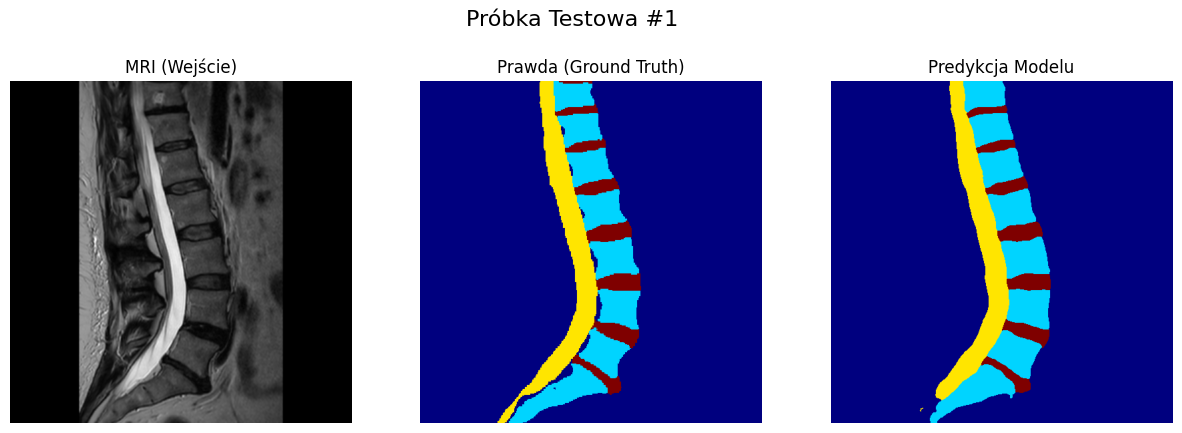

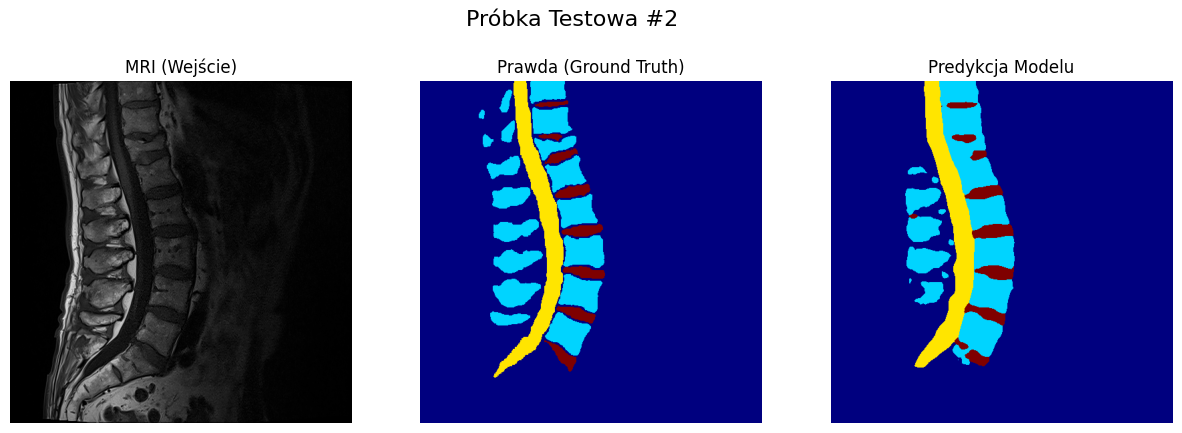

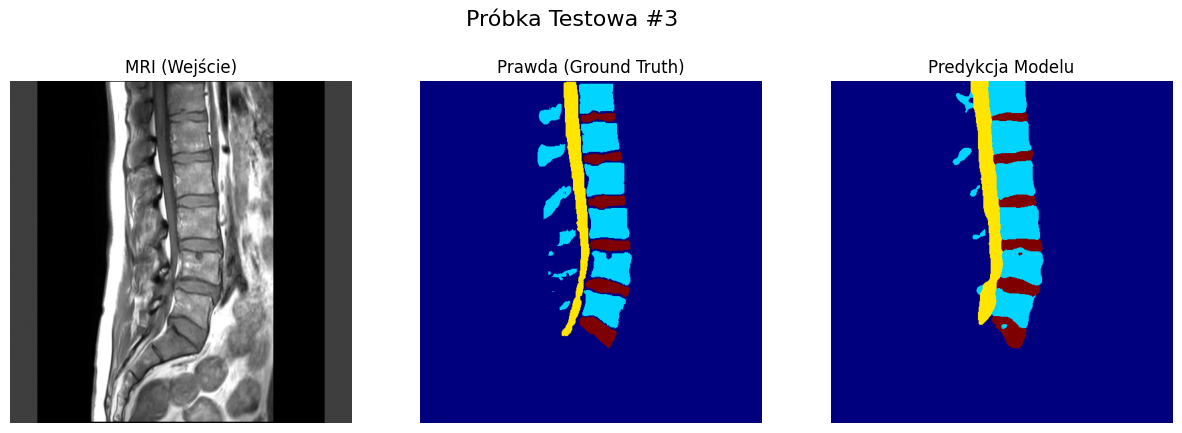

In [ ]:
tl_model = TransferLearning_model1(model_name="nvidia/mit-b0")


nvidia/mit-b2

--- URUCHAMIAM TRANSFER LEARNING: nvidia/mit-b2 ---
Wczytywanie i dzielenie danych...
Dane podzielone:
  -> Trening:   256 (70%)
  -> Walidacja: 73 (20%)
  -> Test:      38 (10%)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/igor-lechoszest/anaconda3/envs/AI_Diag/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Aff

Rozpoczynam trening modelu nvidia/mit-b2...
Epoka [1/10] | LR: 5.00e-05 | Train Loss: 1.0063 | Val Loss: 0.5776
Epoka [2/10] | LR: 5.00e-05 | Train Loss: 0.4170 | Val Loss: 0.3006
Epoka [3/10] | LR: 5.00e-05 | Train Loss: 0.3014 | Val Loss: 0.2340
Epoka [4/10] | LR: 5.00e-05 | Train Loss: 0.2541 | Val Loss: 0.1935
Epoka [5/10] | LR: 5.00e-05 | Train Loss: 0.2225 | Val Loss: 0.1782
Epoka [6/10] | LR: 5.00e-05 | Train Loss: 0.1952 | Val Loss: 0.1590
Epoka [7/10] | LR: 5.00e-05 | Train Loss: 0.1831 | Val Loss: 0.1478
Epoka [8/10] | LR: 5.00e-05 | Train Loss: 0.1723 | Val Loss: 0.1391
Epoka [9/10] | LR: 5.00e-05 | Train Loss: 0.1640 | Val Loss: 0.1373
Epoka [10/10] | LR: 5.00e-05 | Train Loss: 0.1587 | Val Loss: 0.1281

Trening nvidia/mit-b2 zakończony. Testowanie...

--- ROZPOCZYNAM TESTOWANIE NA ZBIORZE TESTOWYM ---

=== WYNIKI TESTU (DICE SCORE) ===
Klasa                | Dice Score
-----------------------------------
Tło                  | 0.9890
Kręgi                | 0.9111
Dyski    

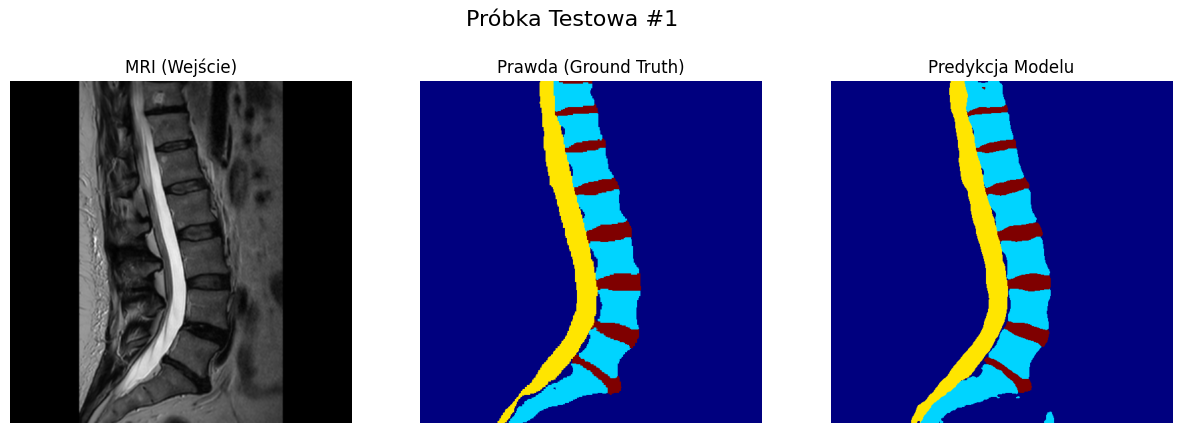

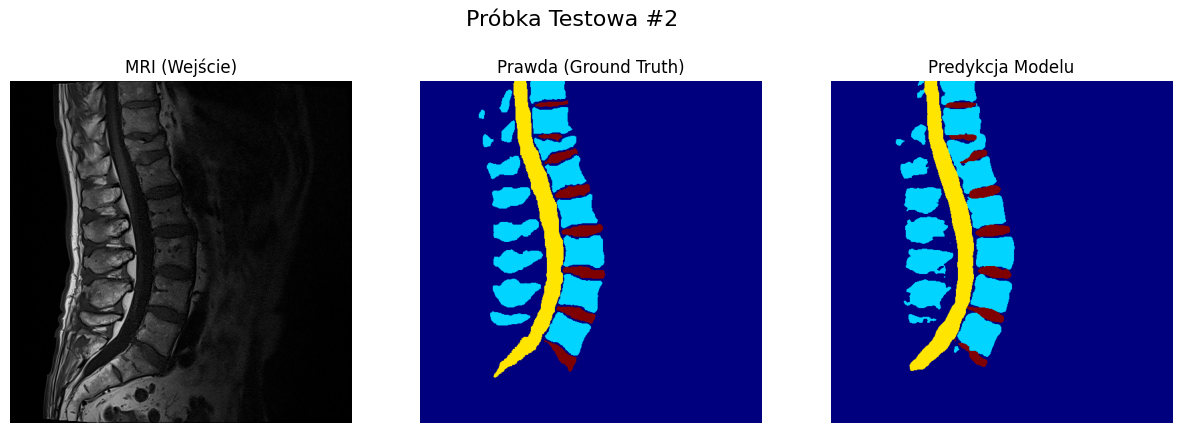

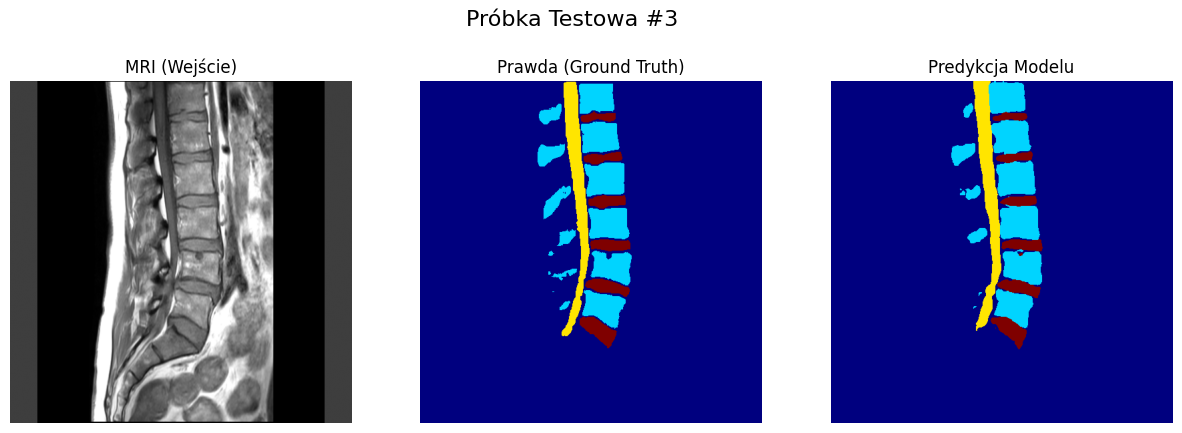

In [ ]:
tl_model_b2 = TransferLearning_model1(model_name="nvidia/mit-b2")

# modele UperNetForSemanticSegmentation, BeitForSemanticSegmentation

In [4]:
from transformers import UperNetForSemanticSegmentation, BeitForSemanticSegmentation

class HuggingFaceSwinUperNet(nn.Module):
    def __init__(self, num_classes=4, model_name="openmmlab/upernet-swin-tiny"):
        super().__init__()
        # UperNet to 'głowa' segmentacyjna, która często używa Swina jako backbone
        self.model = UperNetForSemanticSegmentation.from_pretrained(
            model_name,
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )
        
    def forward(self, x):
        # x: [Batch, 1, 512, 512] -> [Batch, 3, 512, 512]
        x = x.repeat(1, 3, 1, 1)
        
        # Swin/UperNet w HF zwraca logits
        outputs = self.model(pixel_values=x)
        
        # Upsampling do oryginalnego rozmiaru (512x512)
        logits = nn.functional.interpolate(
            outputs.logits, 
            size=(512, 512), 
            mode="bilinear", 
            align_corners=False
        )
        return logits

# --- 2. Wrapper dla BEiT ---
class HuggingFaceBeit(nn.Module):
    def __init__(self, num_classes=4, model_name="microsoft/beit-base-finetuned-ade-640-640"):
        super().__init__()
        self.model = BeitForSemanticSegmentation.from_pretrained(
            model_name,
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )
        
    def forward(self, x):
        # 1. Konwersja MRI (1 kanał) -> RGB (3 kanały)
        x = x.repeat(1, 3, 1, 1)
        
        # 2. POPRAWKA: Resize do 640x640 (Wymóg tego konkretnego modelu BEiT)
        # Jeśli wejście ma inny rozmiar niż 640x640, skalujemy je w górę
        if x.shape[2] != 640 or x.shape[3] != 640:
            x = nn.functional.interpolate(
                x, 
                size=(640, 640), 
                mode='bilinear', 
                align_corners=False
            )
        
        # 3. Przejście przez model
        outputs = self.model(pixel_values=x)
        
        # 4. Skalowanie wyniku z powrotem do 512x512 (żeby pasował do masek Ground Truth)
        logits = nn.functional.interpolate(
            outputs.logits, 
            size=(512, 512), 
            mode="bilinear", 
            align_corners=False
        )
        return logits

In [5]:
def TransferLearning_model2(model_type="segformer", model_name="nvidia/mit-b0"):
    """
    model_type: 'segformer', 'swin', lub 'beit'
    model_name: nazwa z HuggingFace Hub
    """
    print(f"--- START TRANSFER LEARNING: Typ={model_type}, Nazwa={model_name} ---")
    
    # 1. Konfiguracja
    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')

    # 2. Dane
    train_loader, val_loader, test_loader = data_loading_for_model()

    # 3. Wybór Modelu
    num_classes = 4
    
    if model_type == "segformer":
        # Zakładam, że klasę HuggingFaceSegFormer masz zdefiniowaną wcześniej
        model = HuggingFaceSegFormer(num_classes=num_classes, model_name=model_name).to(device)
    elif model_type == "swin":
        model = HuggingFaceSwinUperNet(num_classes=num_classes, model_name=model_name).to(device)
    elif model_type == "beit":
        model = HuggingFaceBeit(num_classes=num_classes, model_name=model_name).to(device)
    else:
        raise ValueError(f"Nieznany typ modelu: {model_type}")

    criterion = HybridLoss().to(device)
    
    # Dla BEiT i Swin warto uważać z LR, są delikatne. 5e-5 jest bezpieczne.
    optimizer = optim.Adam(model.parameters(), lr=5e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    num_epochs = 10
    best_val_loss = float('inf')
    # Tworzymy bezpieczną nazwę pliku
    safe_name = model_name.replace('/', '_').replace('-', '_')
    save_name = f"best_{model_type}_{safe_name}.pth"
    
    print(f"Rozpoczynam trening. Model zostanie zapisany jako: {save_name}")
    
    # --- PĘTLA TRENINGOWA (Identyczna jak wcześniej) ---
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for images, masks in train_loader:
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.long)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        avg_train_loss = train_loss / len(train_loader)
        
        # Walidacja
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device, dtype=torch.float32)
                masks = masks.to(device, dtype=torch.long)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"Epoka [{epoch+1}/{num_epochs}] | LR: {current_lr:.2e} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_name)

    print(f"\nTrening {model_type} zakończony. Testowanie...")
    
    # 4. Testowanie
    model.load_state_dict(torch.load(save_name))
    evaluate_on_test_set(model, test_loader, device, num_classes)
    
    # Czyszczenie pamięci po dużym modelu
    torch.cuda.empty_cache() 

    return model

Swin Transformer


>>> START: SWIN TRANSFORMER (Tiny) <<<
--- START TRANSFER LEARNING: Typ=swin, Nazwa=openmmlab/upernet-swin-tiny ---
Wczytywanie i dzielenie danych...
Dane podzielone:
  -> Trening:   256 (70%)
  -> Walidacja: 73 (20%)
  -> Test:      38 (10%)


Some weights of UperNetForSemanticSegmentation were not initialized from the model checkpoint at openmmlab/upernet-swin-tiny and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 512, 1, 1]) in the checkpoint and torch.Size([4, 512, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([4]) in the model instantiated
- auxiliary_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([4, 256, 1, 1]) in the model instantiated
- auxiliary_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/igor-lechoszest/anaconda3/envs/AI_Diag/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a sp

Rozpoczynam trening. Model zostanie zapisany jako: best_swin_openmmlab_upernet_swin_tiny.pth
Epoka [1/10] | LR: 5.00e-05 | Train: 1.2784 | Val: 0.7315
Epoka [2/10] | LR: 5.00e-05 | Train: 0.4815 | Val: 0.3714
Epoka [3/10] | LR: 5.00e-05 | Train: 0.3370 | Val: 0.2912
Epoka [4/10] | LR: 5.00e-05 | Train: 0.2704 | Val: 0.2152
Epoka [5/10] | LR: 5.00e-05 | Train: 0.2293 | Val: 0.1893
Epoka [6/10] | LR: 5.00e-05 | Train: 0.2054 | Val: 0.1703
Epoka [7/10] | LR: 5.00e-05 | Train: 0.1852 | Val: 0.1534
Epoka [8/10] | LR: 5.00e-05 | Train: 0.1729 | Val: 0.1496
Epoka [9/10] | LR: 5.00e-05 | Train: 0.1693 | Val: 0.1382
Epoka [10/10] | LR: 5.00e-05 | Train: 0.1591 | Val: 0.1323

Trening swin zakończony. Testowanie...

--- ROZPOCZYNAM TESTOWANIE NA ZBIORZE TESTOWYM ---

=== WYNIKI TESTU (DICE SCORE) ===
Klasa                | Dice Score
-----------------------------------
Tło                  | 0.9889
Kręgi                | 0.9059
Dyski                | 0.9090
Sacrum               | 0.8844
---------

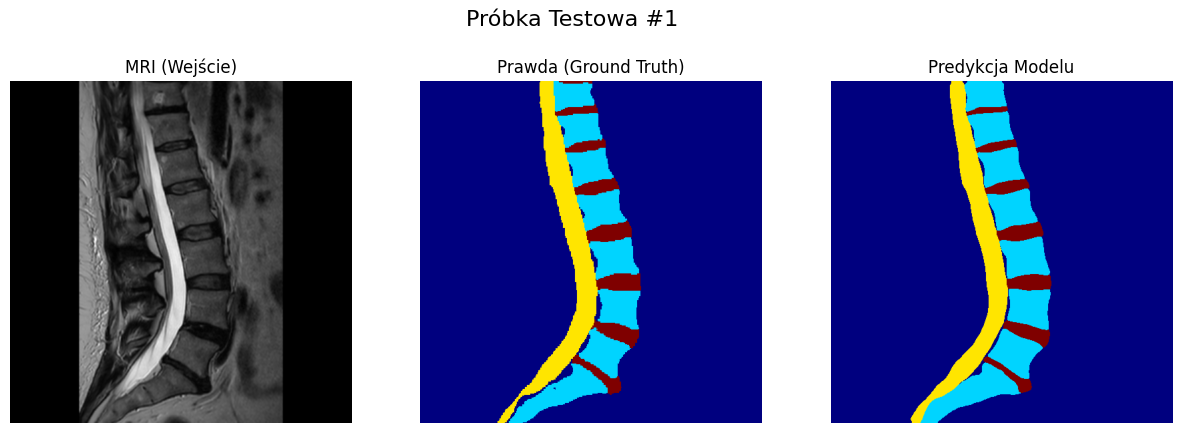

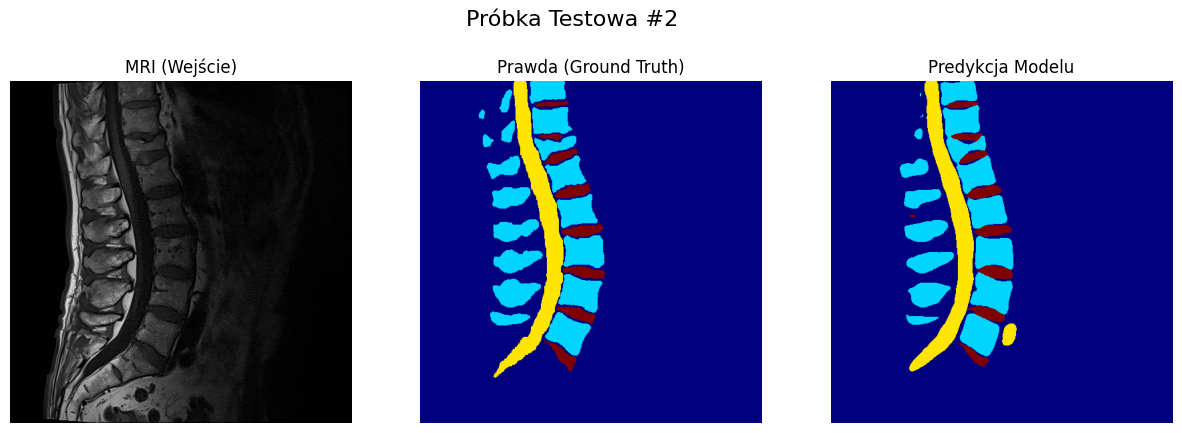

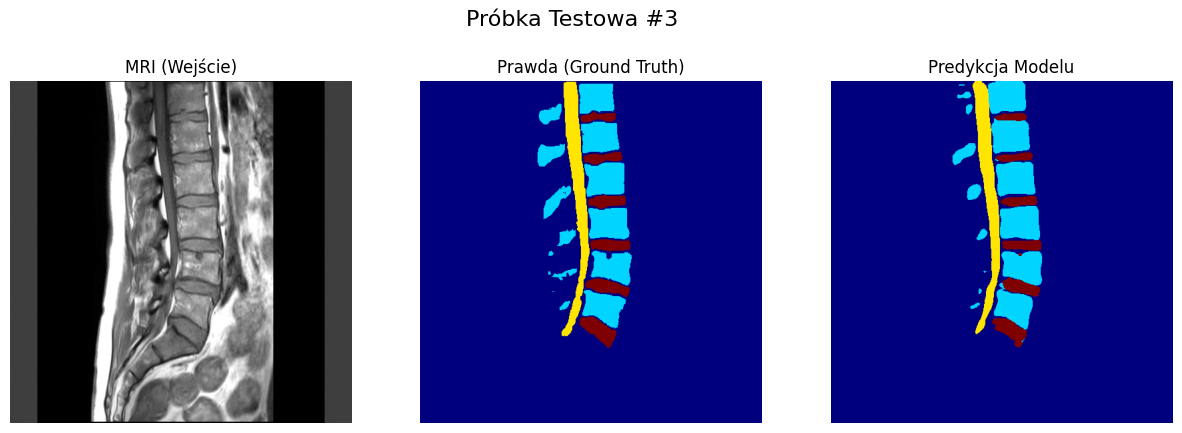

In [6]:
# 1. Swin Transformer (wersja Tiny - dobra na start)
# To architektura UperNet + Swin Backbone
print("\n>>> START: SWIN TRANSFORMER (Tiny) <<<")
swin_model = TransferLearning_model2(
            model_type="swin", 
            model_name="openmmlab/upernet-swin-tiny"
        )


BEiT

In [ ]:
# 2. BEiT (Base - to jest spory model!)
# Uwaga: Może wymagać dużo VRAM. Jeśli wywali błąd, pomiń go.
print("\n>>> START: BEiT (Base) <<<")
beit_model = TransferLearning_model2(
            model_type="beit", 
            model_name="microsoft/beit-base-finetuned-ade-640-640"
        )


>>> START: BEiT (Base) <<<
--- START TRANSFER LEARNING: Typ=beit, Nazwa=microsoft/beit-base-finetuned-ade-640-640 ---
Wczytywanie i dzielenie danych...
Dane podzielone:
  -> Trening:   256 (70%)
  -> Walidacja: 73 (20%)
  -> Test:      38 (10%)


/home/igor-lechoszest/anaconda3/envs/AI_Diag/lib/python3.12/site-packages/transformers/models/beit/configuration_beit.py:197: FutureWarning: The `segmentation_indices` argument is deprecated and will be removed in a future version, use `out_indices` instead.
  warnings.warn(
Some weights of BeitForSemanticSegmentation were not initialized from the model checkpoint at microsoft/beit-base-finetuned-ade-640-640 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([4, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([4]) in the model instantiated
- auxiliary_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([4, 256, 1, 1]) in the model instantiated
- auxiliary_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([4]) 

Rozpoczynam trening. Model zostanie zapisany jako: best_beit_microsoft_beit_base_finetuned_ade_640_640.pth


/home/igor-lechoszest/anaconda3/envs/AI_Diag/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
